Αλεξανδρής Γιώργος-03118195

Γρηγοριάδου Ναταλία-Μαρία-03118940

Σκόρδα Στεφανία-03118852

Ομάδα 7- Kaggle Dataset: K07

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_predict,cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,mean_squared_error,accuracy_score,f1_score,balanced_accuracy_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns; sns.set()
import time
from sklearn.feature_selection import VarianceThreshold
from imblearn.pipeline import Pipeline
from sklearn import neighbors
from sklearn.svm import SVC # "Support vector classifier"


### Εισαγωγή dataset από αρχείο CSV

In [2]:
data = pd.read_csv("./Dry_Bean.csv")

## Εξαγωγή πληροφοριών του dataset

In [3]:
n_samples=data.shape[0]
n_features = data.shape[1] - 1

In [4]:
x = data.drop('Class',axis=1)
y = data[["Class"]]

## Επισκόπηση
* Το dataset που επεξεργαζόμαστε περιέχει 13,611 δείγματα φασολιών από 7 διαφορετικά είδη. Τα features που περιέχονται λήφθηκαν από επεξεργασία φωτογραφιών των δειγμάτων μέσω κατάληλλου computer vision system. Συνολικά, περιέχει 16 feautures, εκ των οποίων τα  12 περιγράφουν τις διαστάσεις των φασολιών και τα υπόλοιπα 4 το σχήμα τους.

* Παρακάτω βλέπουμε κάποια από τα features του dataset και τι ακριβώς περιγράφουν:

|Χαρακτηριστικό      | Περιγραφή                                                                                     |
|--------------------|-----------------------------------------------------------------------------------------------|
|Area (A)            | The area of a bean zone and the number of pixels within its boundaries                        |
Perimeter (P)        |Bean circumference is defined as the length of its border                                      |
Major axis length (L)| The distance between the ends of the longest line that can be drawn from a bean               |
Minor axis length (l)| The longest line that can be drawn from the bean while standing perpendicular to the main axis|
Aspect ratio (K)     | Defines the relationship between L and l                                                      |


## train-test split

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y,train_size=0.8,test_size=0.2, random_state=0)

In [6]:
y_train =  np.ravel(y_train)
y_test = np.ravel(y_test)

x = np.append(x_train, x_test).reshape(13611,16)
y = np.append(y_train, y_test)


## Έλεγχος για απουσιάζουσες τιμές


In [7]:
for i in range(len(x)):
    if(len(x[i]) != 16):
        print("index {} has a problem :(".format(i))

Παρατηρούμε ότι δεν υπάρχουν απουσιάζουσες τιμές σε αυτό το dataset.

{'BARBUNYA': 1322, 'BOMBAY': 522, 'CALI': 1630, 'DERMASON': 3546, 'HOROZ': 1928, 'SEKER': 2027, 'SIRA': 2636}


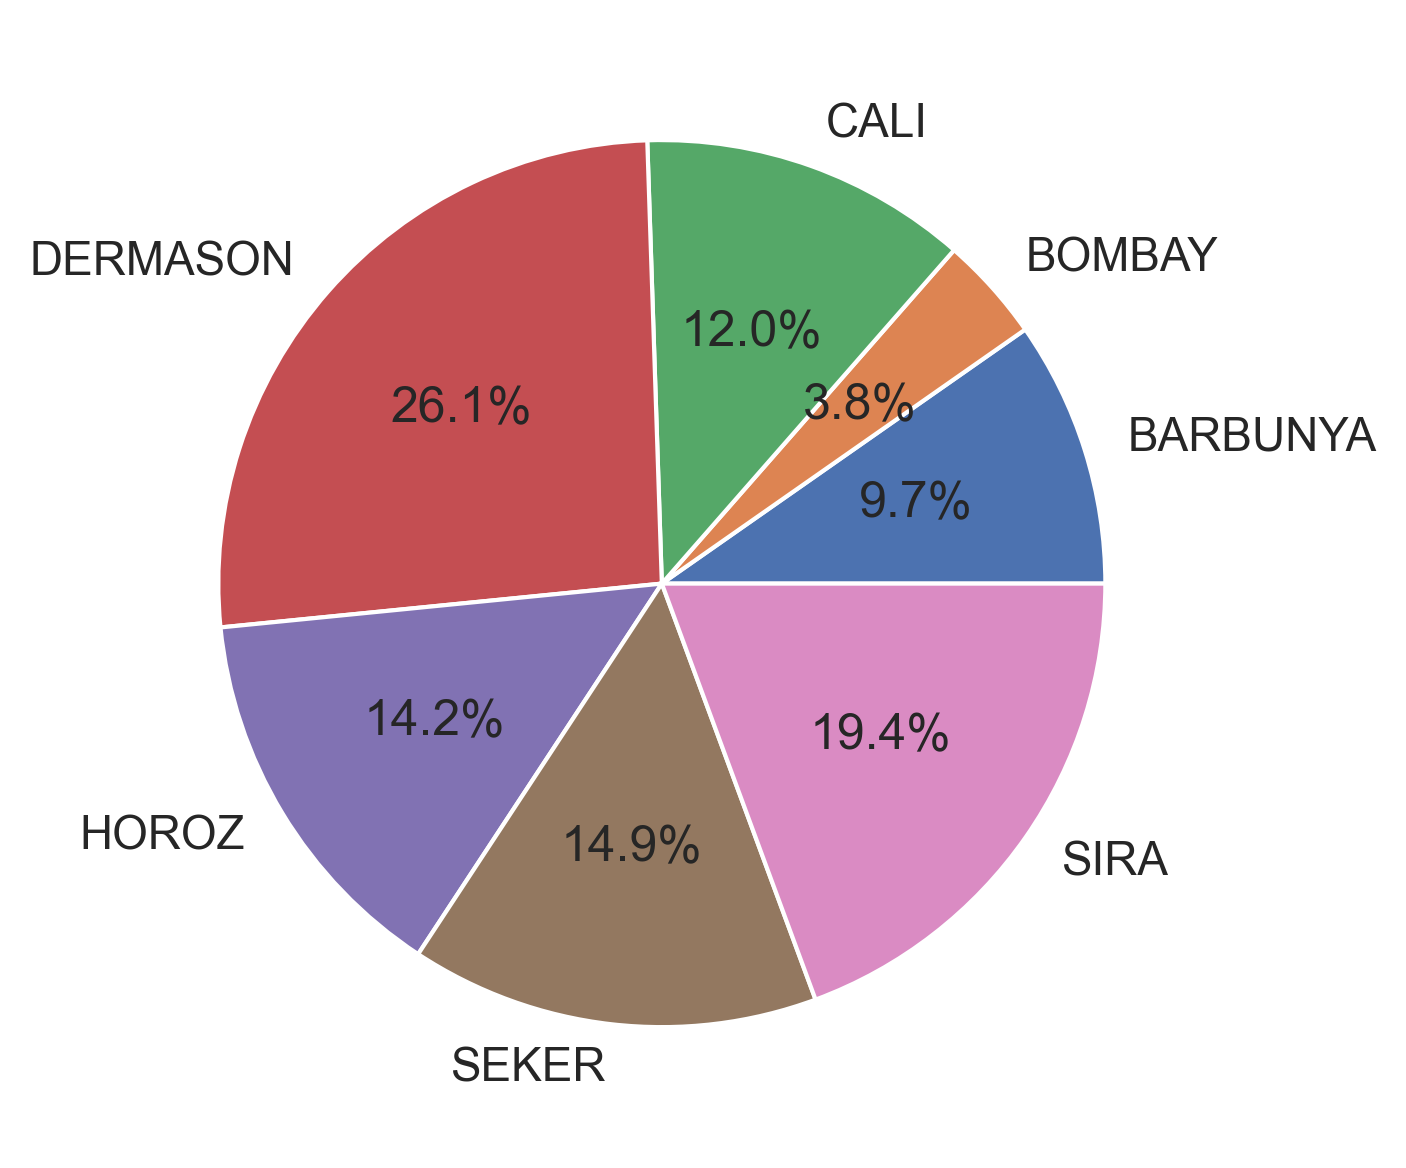

In [10]:
classes=np.unique(y)
class_num={}

for c in classes:
    class_num[c]=0

for i in range(len(y)):
    class_num[y[i]]+=1

print(class_num)
plt.figure(dpi=300)
plt.pie(list(class_num.values()),labels=list(class_num.keys()),autopct="%1.1f%%")
plt.show()

Παρατηρούμε ότι δεν είναι ισορροπημένο το dataset μας. Για πάραδειγμα, η κατηγορία DERMASON έχει περίπου 7 φορές περισσότερα δείγματα από την κατηγορία BOMBAY.

In [11]:
# hold times for train and pred of out of the box
train_time_base = {}
pred_time_base = {}
# dictionary to store all classifier without optimization preds
predictions = {}

## Μετρικές
Επιλέξαμε ως μετρικές το balanced accuracy και το f1 weighted, γιατί οι συγκεκριμένες μετρικές προορίζονται για non-binary και μη ισορροπημένα δεδομένα.  

## Εκτέλεση MLP Out-of-the-box

In [12]:
clf = MLPClassifier(random_state=10)
start_time = time.time()
clf.fit(x_train, y_train)
train_time_base["MLP"] = time.time() - start_time
start_time = time.time()
preds = clf.predict(x_test)
pred_time_base["MLP"] = time.time() - start_time
predictions["MLP"] = preds

acc_MLP= balanced_accuracy_score(y_test, preds)
f1_MLP=f1_score(y_test,preds,average='weighted')

print("MLP accuracy: {:.2f}%".format(acc_MLP*100))
print("MLP f1 score: {:.2f}%".format(f1_MLP*100))



MLP accuracy: 41.58%
MLP f1 score: 16.87%


Επιλέγουμε 10-fold cross validation, μετά από αρκετές δοκιμές.

In [26]:
start_time = time.time()
scores_MLP_acc = cross_val_score(clf,x_train,y_train,cv=10,n_jobs=-1, scoring='balanced_accuracy')
train_time_base["MLP"] = time.time() - start_time
start_time = time.time()
scores_MLP_f1 = cross_val_score(clf,x_train,y_train,cv=10,n_jobs=-1,scoring='f1_weighted')

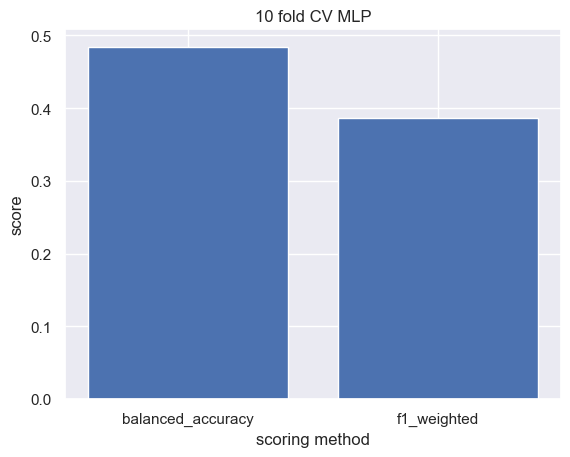

In [31]:
plt.figure()
plt.bar(['balanced_accuracy','f1_weighted'],[np.mean(scores_MLP_acc),np.mean(scores_MLP_f1)])
plt.xlabel("scoring method")
plt.ylabel("score")
plt.title("10 fold CV MLP")
plt.show()

## Εκτέλεση SVM Out-of-the-box

In [28]:
model = SVC(random_state=0)
start_time = time.time()
model.fit(x_train, y_train)
train_time_base["SVM"] = time.time() - start_time
start_time = time.time()
preds =model.predict(x_test)
pred_time_base["SVM"] = time.time() - start_time
predictions["SVM"] = preds

acc_SVM= balanced_accuracy_score(y_test, preds)
f1_SVM=f1_score(y_test,preds,average='weighted')

print("SVM accuracy: {:.2f}%".format(acc_SVM*100))
print("SVM f1 score: {:.2f}%".format(f1_SVM*100))

SVM accuracy: 61.90%
SVM f1 score: 60.77%


In [29]:
scores_SVM_acc = cross_val_score(model,x_train,y_train,cv=10,n_jobs=-1, scoring='balanced_accuracy')
scores_SVM_f1 = cross_val_score(model,x_train,y_train,cv=10,n_jobs=-1,scoring='f1_weighted')

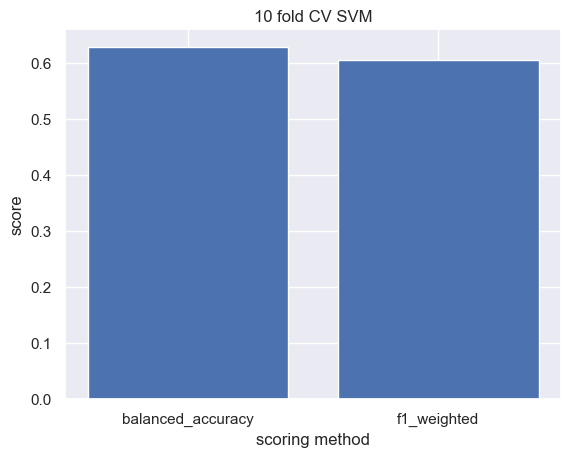

In [30]:
plt.bar(['balanced_accuracy','f1_weighted'],[np.mean(scores_SVM_acc),np.mean(scores_SVM_f1)])
plt.xlabel("scoring method")
plt.ylabel("score")
plt.title("10 fold CV SVM")
plt.show()

## Dummy Classifiers for scale

In [32]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support,f1_score

In [33]:
dum = DummyClassifier()

In [34]:
scores_DUM_acc = cross_val_score(dum,x_train,y_train,cv=10,n_jobs=-1, scoring='balanced_accuracy')
scores_DUM_f1 = cross_val_score(dum,x_train,y_train,cv=10,n_jobs=-1,scoring='f1_weighted')

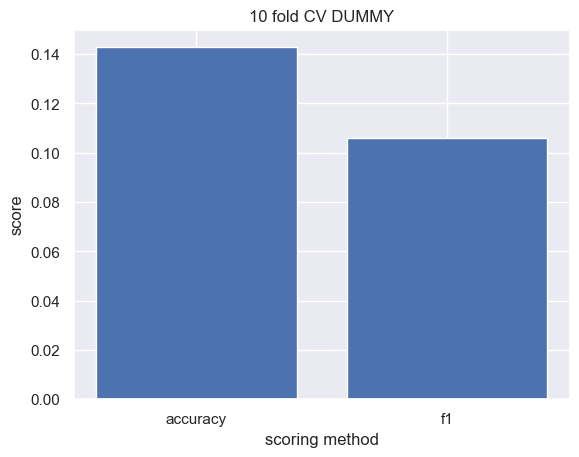

In [35]:
plt.bar(['accuracy','f1'],[np.mean(scores_DUM_acc),np.mean(scores_DUM_f1)])
plt.xlabel("scoring method")
plt.ylabel("score")
plt.title("10 fold CV DUMMY")
plt.show()

In [36]:

accuracy = {}
f1 = {}

accuracy["10-fold CV DUMMY"]= np.mean(scores_DUM_acc)
f1["10-fold CV DUMMY"]= np.mean(scores_DUM_f1)

accuracy["MLP OTB"]= acc_MLP
f1["MLP OTB"]= f1_MLP

accuracy["10-fold CV MLP"]= np.mean(scores_MLP_acc)
f1["10-fold CV MLP"]= np.mean(scores_MLP_f1)

accuracy["SVM OTB"]= acc_SVM
f1["SVM OTB"]= f1_SVM

accuracy["10-fold CV SVM"]= np.mean(scores_SVM_acc)
f1["10-fold CV SVM"]= np.mean(scores_SVM_f1)

def metrics_info(classifier_name, preds):
  global accuracy, f1 
  accuracy[classifier_name] = balanced_accuracy_score(y_test, preds)
  f1[classifier_name] = f1_score(y_test, preds, average = "weighted")
  # print bar plot function
def bar_plot(classifiers, scores, title):
  plt.figure(figsize = (10,6))
  y_pos = np.arange(len(classifiers))
  plt.bar(y_pos, scores, align='center', alpha = 0.9)
  plt.xticks(y_pos, classifiers, rotation = 45,size=10)
  plt.ylabel('Score')
  plt.title(title)
  plt.show()

In [25]:
dc_uniform = DummyClassifier(strategy="uniform")
dc_constant_horoz = DummyClassifier(strategy="constant", constant='horoz'.upper())
dc_constant_sira = DummyClassifier(strategy="constant", constant= 'sira'.upper())
dc_constant_barbunya = DummyClassifier(strategy="constant", constant='barbunya'.upper())
dc_constant_seker = DummyClassifier(strategy="constant", constant='seker'.upper())
dc_constant_bombay = DummyClassifier(strategy="constant",constant='bombay'.upper())
dc_constant_cali = DummyClassifier(strategy="constant",constant='cali'.upper())
dc_constant_dermason = DummyClassifier(strategy="constant",constant='dermason'.upper())
dc_most_frequent = DummyClassifier(strategy="most_frequent")
dc_stratified = DummyClassifier(strategy="stratified")

# with the fit method we train the classifier with the train set
# with the predict method predictions occur based on the input data
start_time = time.time()
dc_uniform.fit(x_train, y_train)
train_time_base["DC Uniform"] = time.time() - start_time
start_time = time.time()
predictions["DC Uniform"] = dc_uniform.predict(x_test)
pred_time_base["DC Uniform"] = time.time() - start_time
start_time = time.time()
dc_constant_horoz.fit(x_train, y_train)
train_time_base["DC Constant horoz"] = time.time() - start_time
start_time = time.time()
predictions["DC Constant horoz"] = dc_constant_horoz.predict(x_test)
pred_time_base["DC Constant horoz"] = time.time() - start_time
start_time = time.time()
dc_constant_sira.fit(x_train, y_train)
train_time_base["DC Constant sira"] = time.time() - start_time
start_time = time.time()
predictions["DC Constant sira"] = dc_constant_sira.predict(x_test)
pred_time_base["DC Constant sira"] = time.time() - start_time
start_time = time.time()

start_time = time.time()
dc_constant_bombay.fit(x_train, y_train)
train_time_base["DC Constant bombay"] = time.time() - start_time
start_time = time.time()
predictions["DC Constant bombay"] = dc_constant_bombay.predict(x_test)
pred_time_base["DC Constant bombay"] = time.time() - start_time
start_time = time.time()

start_time = time.time()
dc_constant_cali.fit(x_train, y_train)
train_time_base["DC Constant cali"] = time.time() - start_time
start_time = time.time()
predictions["DC Constant cali"] = dc_constant_cali.predict(x_test)
pred_time_base["DC Constant cali"] = time.time() - start_time
start_time = time.time()

start_time = time.time()
dc_constant_dermason.fit(x_train, y_train)
train_time_base["DC Constant dermason"] = time.time() - start_time
start_time = time.time()
predictions["DC Constant dermason"] = dc_constant_dermason.predict(x_test)
pred_time_base["DC Constant dermason"] = time.time() - start_time
start_time = time.time()

dc_constant_barbunya.fit(x_train, y_train)
train_time_base["DC Constant barbunya"] = time.time() - start_time

start_time = time.time()
predictions["DC Constant barbunya"] = dc_constant_barbunya.predict(x_test)
pred_time_base["DC Constant barbunya"] = time.time() - start_time
start_time = time.time()
dc_constant_seker.fit(x_train, y_train)
train_time_base["DC Constant seker"] = time.time() - start_time
start_time = time.time()
predictions["DC Constant seker"] = dc_constant_seker.predict(x_test)
pred_time_base["DC Constant seker"] = time.time() - start_time
start_time = time.time()
dc_most_frequent.fit(x_train, y_train)
train_time_base["DC Most Frequent"] = time.time() - start_time
start_time = time.time()
predictions["DC Most Frequent"] = dc_most_frequent.predict(x_test)
pred_time_base["DC Most Frequent"] = time.time() - start_time
start_time = time.time()
dc_stratified.fit(x_train, y_train)
train_time_base["DC Stratified"] = time.time() - start_time
start_time = time.time()
predictions["DC Stratified"] = dc_stratified.predict(x_test)
pred_time_base["DC Stratified"] = time.time() - start_time

metrics_info("MLP",predictions["MLP"])
metrics_info("SVM",predictions["SVM"])
metrics_info("DC Uniform", predictions["DC Uniform"])
metrics_info("DC Constant horoz", predictions["DC Constant horoz"])
metrics_info("DC Constant sira", predictions["DC Constant sira"])
metrics_info("DC Constant barbunya", predictions["DC Constant barbunya"])
metrics_info("DC Constant seker", predictions["DC Constant seker"])
metrics_info("DC Constant bombay", predictions["DC Constant bombay"])
metrics_info("DC Constant cali", predictions["DC Constant cali"])
metrics_info("DC Constant dermason", predictions["DC Constant dermason"])
metrics_info("DC Most Frequent", predictions["DC Most Frequent"])
metrics_info("DC Stratified", predictions["DC Stratified"])


## Παρουσίαση αποτελεσμάτων και συμπερασμάτων

                10-fold CV DUMMY   MLP OTB  10-fold CV MLP   SVM OTB  \
Accuracy Score          0.142857  0.415772        0.484015  0.618961   
F1 Score                0.105953  0.168746        0.386724  0.607678   

                10-fold CV SVM  
Accuracy Score        0.628690  
F1 Score              0.605826  


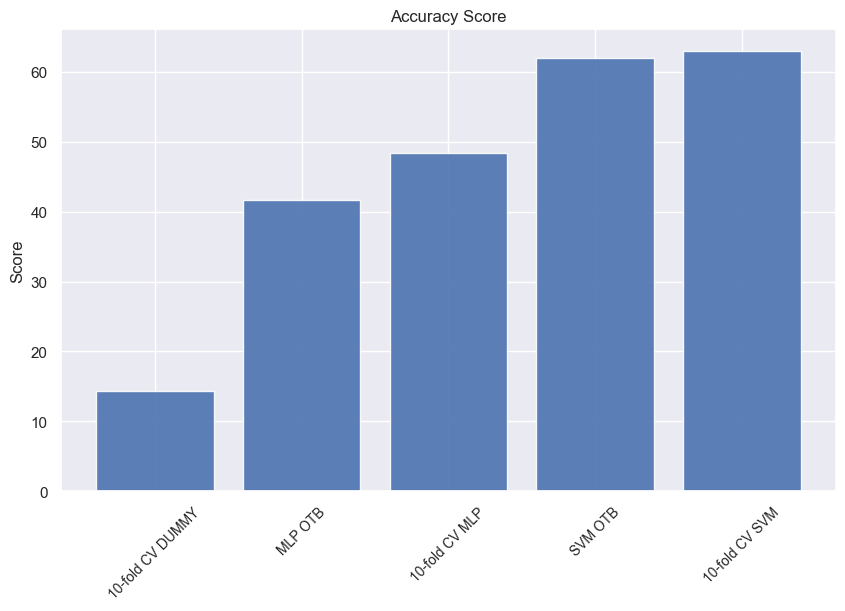

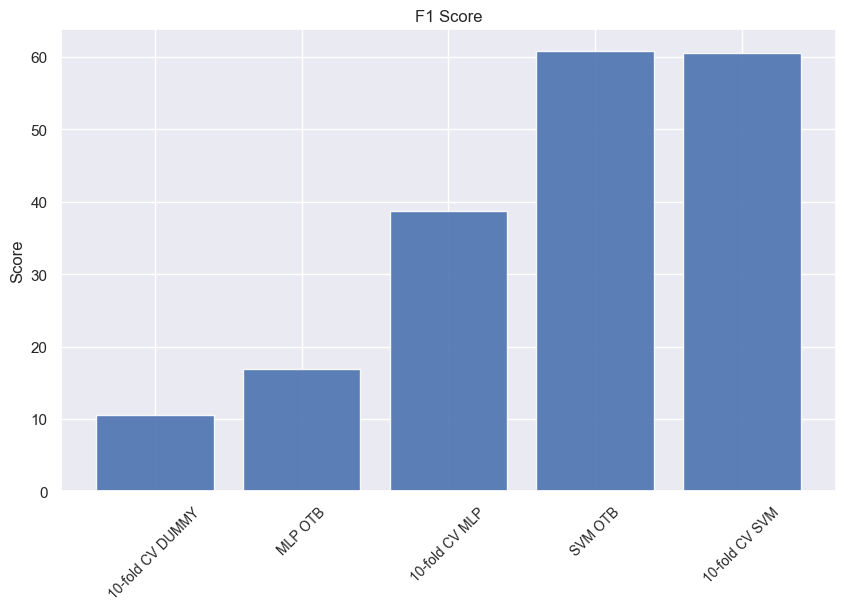

In [37]:

classifier_labels = list(accuracy.keys())
classifier_accuracy = list(accuracy.values())
classifier_f1 = list(f1.values())
    
data = []
data.append(list(accuracy.values()))
data.append(list(f1.values()))
print(pd.DataFrame(data, index = ["Accuracy Score", "F1 Score"], columns = list(accuracy.keys())))

bar_plot(classifier_labels, [i*100 for i in classifier_accuracy], "Accuracy Score")
bar_plot(classifier_labels, [i*100 for i in classifier_f1], "F1 Score")


In [38]:
data = []
data.append(list(accuracy.values()))
data.append(list(f1.values()))
pd.DataFrame(data, index = ["Accuracy Score", "F1 Score"], columns = list(accuracy.keys()))


,10-fold CV DUMMY,MLP OTB,10-fold CV MLP,SVM OTB,10-fold CV SVM
Accuracy Score,0.142857,0.415772,0.484015,0.618961,0.628690
F1 Score,0.105953,0.168746,0.386724,0.607678,0.605826


## Βελτιστοποίηση

### Προεπεξεργασία

In [39]:
selector = VarianceThreshold(threshold=0.00001)
train_reduced = selector.fit_transform(x_train)
mask = selector.get_support()
test_reduced = np.array(x_test)[:,mask]
print("Features Used = {}".format(np.shape(test_reduced)[1]))

Features Used = 14


Μετά από δοκιμές καταλήξαμε στην απομόνωση 2 χαρακτηριστικών και επαναλαμβάνουμε την ίδια διαδικασία με τα υπόλοιπα 14 features

In [41]:
clf = MLPClassifier(random_state=10, max_iter=3000)
start_time = time.time()
clf.fit(train_reduced, y_train)
train_time_base["MLP"] = time.time() - start_time
start_time = time.time()
preds = clf.predict(test_reduced)
pred_time_base["MLP"] = time.time() - start_time
predictions["MLP"] = preds
acc_MLP= balanced_accuracy_score(y_test, preds)
f1_MLP=f1_score(y_test,preds,average='weighted')
accuracy["MLP preprocessing"]= acc_MLP
f1["MLP preprocessing"]= f1_MLP

# make a nice print out of the results
print("MLP preprocessing")
print("Accuracy: {:.2f}".format(acc_MLP))
print("F1 Score: {:.2f}".format(f1_MLP))

MLP preprocessing
Accuracy: 0.53
F1 Score: 0.52


In [42]:
model = SVC(random_state=0,max_iter=3000)
start_time = time.time()
model.fit(train_reduced, y_train)
train_time_base["SVM"] = time.time() - start_time
start_time = time.time()
preds = model.predict(test_reduced)
pred_time_base["SVM"] = time.time() - start_time
predictions["SVM"] = preds
acc_SVM= balanced_accuracy_score(y_test, preds)
f1_SVM=f1_score(y_test,preds,average='weighted')
accuracy["SVM preprocessing"]= acc_SVM
f1["SVM preprocessing"]= f1_SVM

# make a nice print out of the results
print("SVM preprocessing")
print("Accuracy: {:.2f}".format(acc_SVM))
print("F1 Score: {:.2f}".format(f1_SVM))


SVM preprocessing
Accuracy: 0.62
F1 Score: 0.61


### Συμπεράσματα 
Μετά από αρκετές επαναλήψεις εκτελέσεων των 2 classifiers παρατηρούμε ότι με την διατήρηση 14 features υπάρχει μία μικρή αύξηση των μετρικών. Δεν χρησιμοποιήσαμε άλλες τεχνικές προεπεξεργασίας καθώς δεν υπάρχουν ελλειπείς τιμές και η βελτιστοποιημένη προεπεξεργασία τείνει να ταυτίζεται με το pipeline που περιγράφεται παρακάτω.

### Pipeline

In [43]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler # φέρνουμε τον StandarScaler ως transformer που έχει .transform kai ΄όχι ως scale()
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA

selector = VarianceThreshold(0.00001)
scaler = StandardScaler()
ros = RandomOverSampler()
pca = PCA()

pipe = Pipeline(steps = [('selector',selector),('scaler', scaler),('sampler',ros),('pca',pca),('clf',clf)], memory = 'tmp')
timer = time.time()
pipe.fit(x_train,y_train)
demo_fit_time = time.time() - timer
timer = time.time()
pred_mlp = pipe.predict(x_test)
demo_pred_time = time.time() - timer

accuracy["MLP pipeline"] = balanced_accuracy_score(pred_mlp,y_test)
f1["MLP pipeline"] = f1_score(pred_mlp,y_test,average="weighted")

model = SVC(random_state=0)
pipe_svm = Pipeline(steps = [('selector',selector),('scaler', scaler),('sampler',ros),('pca',pca),('clf',model)], memory = 'tmp')
timer = time.time()
pipe_svm.fit(x_train,y_train)
demo_fit_time_svm = time.time() - timer
timer = time.time()
pred_svm = pipe_svm.predict(x_test)
demo_pred_time_svm = time.time() - timer

accuracy["SVM pipeline"] = balanced_accuracy_score(pred_svm,y_test)
f1["SVM pipeline"] = f1_score(pred_svm,y_test,average="weighted")

print("For classifier MLP Accuracy = {} , f1 = {}".format(accuracy["MLP pipeline"],f1["MLP pipeline"]))
print("For classifier SVM Accuracy = {} , f1 = {}".format(accuracy["SVM pipeline"],f1["SVM pipeline"]))


For classifier MLP Accuracy = 0.942148477205367 , f1 = 0.9324604085903045
For classifier SVM Accuracy = 0.9453374557436351 , f1 = 0.9338572818919884


### Συμπεράσματα 
Παρατηρούμε ότι με την χρήση pipeline αυξάνονται σημαντικά οι δυο μετρικές. Επειδή παρατηρήσαμε ότι η επίδραση του selector δεν ήταν σημαντική, θα σχολιαστούν τα υπόλοιπα στάδια:
* Ο standard scaler χρησιμοποιήθηκε για να κανονικοποιήσει τα δεδομένα, και να περιορίσει τις μεγάλες διακυμάνσεις 
* Επειδή το dataset είναι μη ισορροπημένο, για να εξισορροπήσουμε τις μεγάλες διαφορές χρησιμοποιήσαμε Oversampling
* Για πιο γρήγορη ανάλυση χωρίς να χαθούν ποιοτικά στοιχεία του dataset χρησιμοποιούμε την μέθοδο pca

Με βάση την παραπάνω συλλογιστική εξηγείται η μεγάλη αύξηση των μετρικών.

### GridSearch


In [44]:
vthreshold = list(np.arange(start = 0, stop = 0.00002, step = 0.000005))
print(vthreshold)
n_components = [11,12,13,14]

[0.0, 5e-06, 1e-05, 1.5000000000000002e-05]


In [45]:
estimator_mlp_f1 = GridSearchCV(pipe, dict(selector__threshold=vthreshold, pca__n_components=n_components), cv=10, scoring='f1_weighted', n_jobs=-1)
estimator_mlp_f1.fit(x_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(memory='tmp',
                                steps=[('selector',
                                        VarianceThreshold(threshold=1e-05)),
                                       ('scaler', StandardScaler()),
                                       ('sampler', RandomOverSampler()),
                                       ('pca', PCA()),
                                       ('clf',
                                        MLPClassifier(max_iter=3000,
                                                      random_state=10))]),
             n_jobs=-1,
             param_grid={'pca__n_components': [11, 12, 13, 14],
                         'selector__threshold': [0.0, 5e-06, 1e-05,
                                                 1.5000000000000002e-05]},
             scoring='f1_weighted')

In [46]:
MLPF = estimator_mlp_f1.best_score_
MLPF


0.9283841959750596

In [47]:
estimator_mlp_acc = GridSearchCV(pipe, dict(selector__threshold=vthreshold, pca__n_components=n_components), cv=10, scoring='balanced_accuracy', n_jobs=-1)
estimator_mlp_acc.fit(x_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(memory='tmp',
                                steps=[('selector',
                                        VarianceThreshold(threshold=1e-05)),
                                       ('scaler', StandardScaler()),
                                       ('sampler', RandomOverSampler()),
                                       ('pca', PCA()),
                                       ('clf',
                                        MLPClassifier(max_iter=3000,
                                                      random_state=10))]),
             n_jobs=-1,
             param_grid={'pca__n_components': [11, 12, 13, 14],
                         'selector__threshold': [0.0, 5e-06, 1e-05,
                                                 1.5000000000000002e-05]},
             scoring='balanced_accuracy')

In [48]:
MLPA = estimator_mlp_acc.best_score_
MLPA

0.9408977565466895

In [49]:
estimator_svm_f1 = GridSearchCV(pipe_svm, dict(selector__threshold=vthreshold, pca__n_components=n_components), cv=10, scoring='f1_weighted', n_jobs=-1)
estimator_svm_f1.fit(x_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(memory='tmp',
                                steps=[('selector',
                                        VarianceThreshold(threshold=1e-05)),
                                       ('scaler', StandardScaler()),
                                       ('sampler', RandomOverSampler()),
                                       ('pca', PCA()),
                                       ('clf', SVC(random_state=0))]),
             n_jobs=-1,
             param_grid={'pca__n_components': [11, 12, 13, 14],
                         'selector__threshold': [0.0, 5e-06, 1e-05,
                                                 1.5000000000000002e-05]},
             scoring='f1_weighted')

In [51]:
SVMF = estimator_svm_f1.best_score_
SVMF

0.9266985307314162

In [52]:
estimator_svm_acc = GridSearchCV(pipe_svm, dict(selector__threshold=vthreshold, pca__n_components=n_components), cv=10, scoring='balanced_accuracy', n_jobs=-1)
estimator_svm_acc.fit(x_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(memory='tmp',
                                steps=[('selector',
                                        VarianceThreshold(threshold=1e-05)),
                                       ('scaler', StandardScaler()),
                                       ('sampler', RandomOverSampler()),
                                       ('pca', PCA()),
                                       ('clf', SVC(random_state=0))]),
             n_jobs=-1,
             param_grid={'pca__n_components': [11, 12, 13, 14],
                         'selector__threshold': [0.0, 5e-06, 1e-05,
                                                 1.5000000000000002e-05]},
             scoring='balanced_accuracy')

In [53]:
SVMA = estimator_svm_acc.best_score_
SVMA


0.939159305525264

In [54]:
scores = [MLPF*100,MLPA*100,SVMF*100,SVMA*100]
names = ["MLP f1","MLP accuracy","SVM f1","SVM accuracy"]

CLASSIFIRER MLP f1 --> 92.83841959750596
CLASSIFIRER MLP accuracy --> 94.08977565466895
CLASSIFIRER SVM f1 --> 92.66985307314161
CLASSIFIRER SVM accuracy --> 93.9159305525264


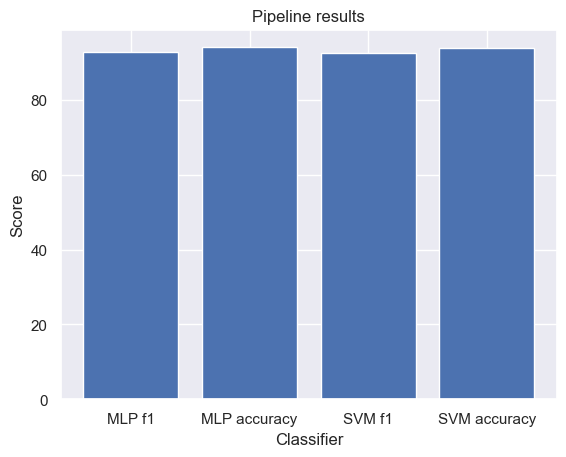

In [55]:
for i in range(len(scores)):
    print("CLASSIFIRER {} --> {}".format(names[i],scores[i]))


# make a bar plot for the pipeline results
plt.bar(names, scores)
plt.title("Pipeline results")
plt.ylabel("Score")
plt.xlabel("Classifier")
plt.show()

Παρατηρούμε ότι η βελτιστοποίηση με gridsearch δεν εμφανίζει σημαντικές διαφορές σε σχέση με την χρήση pipelines.

## OPTUNA



In [64]:
import optuna
import sklearn.datasets
from sklearn.datasets import fetch_openml
import sklearn.neural_network

def objective(trial):
    vr = VarianceThreshold(0.0001)
    sc = StandardScaler()
    

    score = 0
  
    x_train, x_test, y_train, y_test = train_test_split(x, y,train_size=0.8,test_size=0.2, random_state=0)
    y_train =  np.ravel(y_train)
    y_test = np.ravel(y_test)
    
    x_train = vr.fit_transform(x_train)
    mask = vr.get_support()
    x_test = np.array(x_test)[:,mask]

    x_train = sc.fit_transform(x_train)
    x_test = sc.fit_transform(x_test)
    
        # Sample hyper parameters
    activation = trial.suggest_categorical('activation', ["identity", "logistic", "tanh", "relu"])
    solver = trial.suggest_categorical("solver", 
                                              ["sgd", "adam"])
    tol = trial.suggest_float('tol', 1e-8,1e-1, step= 1e-7)
    learning_rate = trial.suggest_categorical('learning_rate', 
                                           ["constant","invscaling"])
    layers = trial.suggest_int('layers',100,1000,100)
        # Construct the model
    clf = MLPClassifier(activation=activation,
                               solver=solver,
                              tol=tol,
                               learning_rate=learning_rate,
                               hidden_layer_sizes=layers, random_state=0, max_iter=3000
                               )

    score = np.mean(cross_val_score(clf,x_train,y_train,scoring='balanced_accuracy',cv=10))
    
        

    return score


    

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)


[I 2022-12-04 17:55:08,666] A new study created in memory with name: no-name-02055809-05d1-4dbc-937a-1dbb817d4be2
C:\Users\ΒΑΣΙΛΗΣ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [1e-08, 0.1] and step=1e-07, but the range is not divisible by `step`. It will be replaced by [1e-08, 0.09999991].
  warnings.warn(
[I 2022-12-04 17:55:20,117] Trial 0 finished with value: 0.9269905862925965 and parameters: {'activation': 'relu', 'solver': 'adam', 'tol': 0.01710611, 'learning_rate': 'invscaling', 'layers': 500}. Best is trial 0 with value: 0.9269905862925965.
C:\Users\ΒΑΣΙΛΗΣ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [1e-08, 0.1] and step=1e-07, but the range is not divisible by `step`. It w

In [65]:
def objective_svm(trial):
    vr = VarianceThreshold(0.0001)
    sc = StandardScaler()

    score = 0
  
    x_train, x_test, y_train, y_test = train_test_split(x, y,train_size=0.8,test_size=0.2, random_state=0)
    y_train =  np.ravel(y_train)
    y_test = np.ravel(y_test)
    
    x_train = vr.fit_transform(x_train)
    mask = vr.get_support()
    x_test = np.array(x_test)[:,mask]

    x_train = sc.fit_transform(x_train)
    x_test = sc.fit_transform(x_test)
 
    # Sample hyper parameters
    C = trial.suggest_float('C', 1e-10, 1)
    kernel = trial.suggest_categorical('kernel',['poly','rbf','sigmoid'])
    degree = trial.suggest_int('degree',1, 50)
    
    clf = SVC(C=C,kernel=kernel,degree=degree, random_state=0, max_iter=3000)
    score = np.mean(cross_val_score(clf,x_train,y_train,scoring='balanced_accuracy',cv=10))
    return score


    

study = optuna.create_study(direction='maximize')
study.optimize(objective_svm, n_trials=50)


[I 2022-12-04 18:07:13,696] A new study created in memory with name: no-name-9c7f91de-d02b-4471-bb62-c7f114ce5190
[I 2022-12-04 18:07:18,991] Trial 0 finished with value: 0.9282959748371317 and parameters: {'C': 0.965958142741947, 'kernel': 'rbf', 'degree': 15}. Best is trial 0 with value: 0.9282959748371317.
[I 2022-12-04 18:07:24,547] Trial 1 finished with value: 0.9279498644865611 and parameters: {'C': 0.6631314408228924, 'kernel': 'rbf', 'degree': 33}. Best is trial 0 with value: 0.9282959748371317.
[I 2022-12-04 18:07:32,522] Trial 2 finished with value: 0.6496304376243807 and parameters: {'C': 0.22146221356352963, 'kernel': 'sigmoid', 'degree': 47}. Best is trial 0 with value: 0.9282959748371317.
[I 2022-12-04 18:07:39,806] Trial 3 finished with value: 0.6281449277493415 and parameters: {'C': 0.3493863718578069, 'kernel': 'sigmoid', 'degree': 7}. Best is trial 0 with value: 0.9282959748371317.
[I 2022-12-04 18:07:46,798] Trial 4 finished with value: 0.9256441835344962 and paramet

### Τελικά συμπεράσματα 
Για την βελτιστοποίηση των αποτελεσμάτων μας, ξεκινώντας από το out-of-the-box μοντέλο εξετάσαμε αν κάποια χαρακτηριστικά μπορούν να παραληφθούν, εφόσον δεν συνεισφέρουν στην ταξινόμηση. Έπειτα από δοκιμές, απορρίψαμε δύο χαρακτηριστικά χωρίς όμως να παρατηρήσουμε μεγάλη διαφορά στις μετρικές. Έπειτα, προχωρήσαμε στην εφαρμογή του pipeline, βάση του σκεπτικού που έχει ήδη αναφερθεί και επιτύχαμε αύξηση της τάξεως του 30%. Μετά την εφαρμογή του Gridsearch, με σκοπό την μείωση των διαστάσεων ή και εύρεσης καλύτερων παραμέτρων, όπως την βέλτιστη διακύμανση δεν προέκυψε σημαντική αύξηση των μετρικών. Τέλος, μετά την χρήση και της βιβλιοθήκης Optuna και με εφαρμογή της βέλτιστης προεπεξεργασίας, όπως είχε παρατηρηθεί στα προηγούμενα βήματα, παρατηρήσαμε πάλι ότι δεν υπάρχει σημαντική αύξηση των αποτελεσμάτων. Έτσι καταλήγουμε ότι οι βέλτιστες μετρικές συγκλίνουν σε ποσοστό 93%.

In [56]:
best_est_MLP_f1 = np.mean(cross_val_score(estimator_mlp_f1.best_estimator_,x_train,y_train,cv=10,scoring="f1_weighted"))
best_est_MLP_acc =  np.mean(cross_val_score(estimator_mlp_acc.best_estimator_,x_train,y_train,cv=10,scoring="balanced_accuracy"))
best_est_SVM_f1 = np.mean(cross_val_score(estimator_svm_f1.best_estimator_ ,x_train,y_train,cv=10,scoring="f1_weighted"))
best_est_SVM_acc = np.mean(cross_val_score(estimator_svm_acc.best_estimator_ ,x_train,y_train,cv=10,scoring="balanced_accuracy"))


In [57]:
old_est_MLP_f1  = f1['10-fold CV MLP']
old_est_MLP_acc = accuracy['10-fold CV MLP']
old_est_SVM_f1   = f1['10-fold CV SVM']
old_est_SVM_acc  = accuracy['10-fold CV SVM']

final_scores_acc = {
    'non optimised MLP' : old_est_MLP_acc,
    'non optimised SVM' : old_est_SVM_acc,
    'optimised MLP' :     best_est_MLP_acc,
    'optimised SVM' :     best_est_SVM_acc,
    'difference MLP' : best_est_MLP_acc - old_est_MLP_acc,
    'difference SVM' : best_est_SVM_acc - old_est_SVM_acc
}

final_scores_f1 = {
    'non optimised MLP' :  old_est_MLP_f1,
    'non optimised SVM' :  old_est_SVM_f1,
    'optimised MLP' :     best_est_MLP_f1,
    'optimised SVM' :     best_est_SVM_f1,
    'difference MLP' : best_est_MLP_f1 - old_est_MLP_f1,
    'difference SVM' : best_est_SVM_f1 - old_est_SVM_f1
}


### Παρουσίαση μετρικών

In [58]:
pd.DataFrame([list(final_scores_acc.values()),list(final_scores_f1.values())], index = ["Accuracy Score", "F1 Score"], columns = list(final_scores_f1.keys()))

,non optimised MLP,non optimised SVM,optimised MLP,optimised SVM,difference MLP,difference SVM
Accuracy Score,0.484015,0.628690,0.940898,0.939159,0.456882,0.310470
F1 Score,0.386724,0.605826,0.928384,0.926699,0.541660,0.320873


### Παρουσίαση πίνακα σύγχυσης 

C:\Users\ΒΑΣΙΛΗΣ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


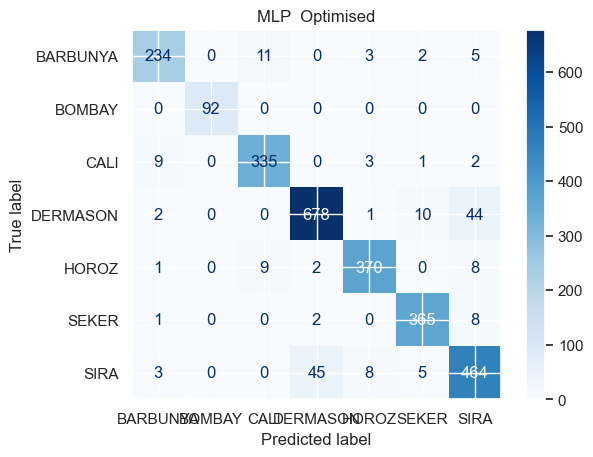

C:\Users\ΒΑΣΙΛΗΣ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


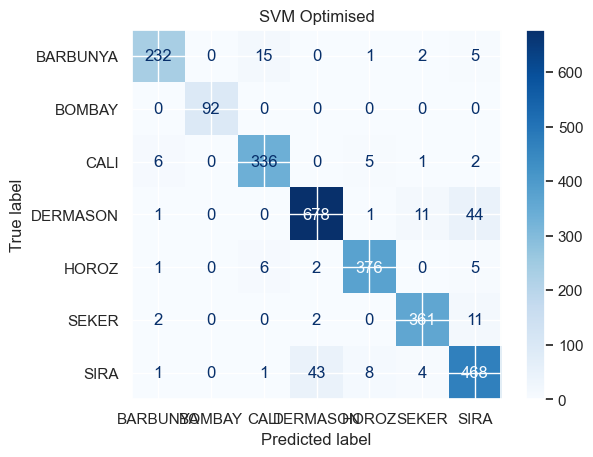

In [63]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt 

best_MLP_confusion = estimator_mlp_acc.best_estimator_
best_SVM_confusion = estimator_svm_acc.best_estimator_

#classifier: Multi-Layer Perceptron
y1_pred= best_MLP_confusion.predict(x_test)

M1 = confusion_matrix(y_test, y1_pred)
#plot M1
plot_confusion_matrix(best_MLP_confusion, x_test, y_test, cmap=plt.cm.Blues)

plt.title("MLP  Optimised")
plt.show()



#classifier: Support Vector
y2_pred = best_SVM_confusion.predict(x_test)
M2 = confusion_matrix(y_test, y2_pred)
plot_confusion_matrix(best_SVM_confusion, x_test, y_test,cmap=plt.cm.Blues)
plt.title("SVM Optimised")
plt.show()